In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

# ----------------------------------------------------------------
# 1. Basic functions (Poisson point generation, max SNR calculation, approximated model, etc.)
# ----------------------------------------------------------------
def resolve_channel_params(preset: str, channel_model: str, K_dB, m):
    """Return (K_dB_resolved, m_resolved) using preset defaults if necessary."""
    if preset.upper() == "HAPS":
        K_default, m_default = 8.0, 3.0
    elif preset.upper() == "LEO":
        K_default, m_default = 12.0, 5.0
    else:
        K_default, m_default = 10.0, 3.0

    K_eff = K_dB if K_dB is not None else K_default
    if channel_model.lower() in ("shadowed_rician", "shadowed-rician", "sr"):
        m_eff = m if m is not None else m_default
    else:
        m_eff = m
    return K_eff, m_eff

def generate_hppp(lambda_intensity, space_range):
    """Generate points from a 2D homogeneous Poisson point process (HPPP)."""
    area = space_range**2
    num_points = np.random.poisson(lambda_intensity * area)

    x_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    y_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    return np.column_stack((x_coords, y_coords))

def sample_rayleigh_power(size: int, mean_power: float = 1.0) -> np.ndarray:
    """
    Sample |h|^2 under Rayleigh small-scale fading.
    For unit-mean power normalization, |h|^2 ~ Exp(mean=1).
    - mean_power: desired mean of |h|^2; keep 1.0 for unit normalization.
    """
    # |h|^2 ~ Exponential with mean = mean_power
    return np.random.exponential(scale=mean_power, size=size)


def sample_rician_power(K_dB, size):
    """Sample |h|^2 for a unit-mean-power Rician channel with K in dB."""
    # Convert K from dB to linear
    K = 10**(K_dB/10.0)
    # LOS and NLOS scaling so that E[|h|^2]=1
    # h = sqrt(K/(K+1)) * 1  +  (1/sqrt(2*(K+1))) * (n_I + j n_Q), n_I,Q ~ N(0,1)
    mu = np.sqrt(K/(K+1.0))
    sigma = 1.0/np.sqrt(2.0*(K+1.0))
    n_real = np.random.normal(loc=0.0, scale=1.0, size=size)
    n_imag = np.random.normal(loc=0.0, scale=1.0, size=size)
    h_real = mu + sigma * n_real
    h_imag =        sigma * n_imag
    power = h_real**2 + h_imag**2
    return power

def sample_shadowed_rician_power(K_dB, m, size):
    """
    Sample |h|^2 for a unit-mean-power Shadowed-Rician channel (κ–μ shadowed with μ=1).
    Model: Randomly shadowed LOS amplitude -> conditional Rician with K' = ξ*K.
    Shadowing factor ξ ~ Gamma(shape=m, scale=1/m)  (unit-mean).
    """
    if m <= 0:
        raise ValueError("m must be positive for shadowed-Rician.")
    K = 10**(K_dB/10.0)
    # Draw shadowing factor for the specular component (unit-mean Gamma)
    xi = np.random.gamma(shape=m, scale=1.0/m, size=size)  # E[xi]=1
    K_prime = K * xi  # shadowed instantaneous K
    # For each sample, generate conditional Rician with K' (vectorized)
    mu = np.sqrt(K_prime/(K_prime+1.0))
    sigma = 1.0/np.sqrt(2.0*(K_prime+1.0))
    n_real = np.random.normal(loc=0.0, scale=1.0, size=size)
    n_imag = np.random.normal(loc=0.0, scale=1.0, size=size)
    h_real = mu + sigma * n_real
    h_imag =        sigma * n_imag
    power = h_real**2 + h_imag**2
    # This construction preserves E[|h|^2]=1 for any K, m.
    return power

# --- SNR calculator ----------------------------------------------------------

def approximated_SPSC_prob(kappa, distance, a=1.0, p=1.0):
    """
        SPSC ≈ exp(- a * (kappa^p) * distance^2).
    """
    return np.exp(- a * kappa**p * distance**2)

def fit_power_kappa_density(kappa_array, spsc_array, distance):
    """
    Estimate (a, p) by curve_fit:
      min_{a,p} Σ [ spsc_i - exp(- a*(kappa_i^p)*distance^2 ) ]^2
    """
    popt, _ = curve_fit(
        lambda xdata, a, p: approximated_SPSC_prob(xdata, distance, a, p),
        kappa_array, 
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt[0], popt[1]

def fit_power_kappa_distance(kappa, spsc_array, distance_array):
    """
    Estimate (a, p) by curve_fit:
      min_{a,p} Σ [ spsc_i - exp(- a*(kappa_i^p)*distance^2 ) ]^2
    """
    popt, _ = curve_fit(
        lambda xdata, a, p: approximated_SPSC_prob(kappa, xdata, a, p),
        distance_array, 
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt[0], popt[1]

def single_experiment(
    eavesdropper_density: float,
    space_range: float,
    alpha: float,
    legit_distance: float,
    jamming_gain: float = 1.0,
    channel_model: str = "rayleigh",
    K_dB=None,
    m=None,
    preset: str = "HAPS",
) -> int:
    """
    Single Monte Carlo trial with both eavesdropper and legitimate link
    using the same channel model (Rayleigh/Rician/Shadowed-Rician).
    """
    # Resolve channel parameters once
    K_eff, m_eff = resolve_channel_params(preset, channel_model, K_dB, m)

    # --- Eavesdropper side ---
    points = generate_hppp(eavesdropper_density, space_range)
    if len(points) > 0:
        distances = np.linalg.norm(points, axis=1)
        if channel_model.lower() == "rayleigh":
            gains = sample_rayleigh_power(len(distances))
        elif channel_model.lower() == "rician":
            gains = sample_rician_power(K_eff, len(distances))
        elif channel_model.lower() in ("shadowed_rician","shadowed-rician","sr"):
            gains = sample_shadowed_rician_power(K_eff, m_eff, len(distances))
        else:
            raise ValueError(f"Unsupported channel_model: {channel_model}")
        max_eve_snr = np.max(gains / (distances**alpha))
    else:
        max_eve_snr = 0.0

    # --- Legitimate link side ---
    if channel_model.lower() == "rayleigh":
        legit_power = sample_rayleigh_power(1)[0]
    elif channel_model.lower() == "rician":
        legit_power = sample_rician_power(K_eff, 1)[0]
    elif channel_model.lower() in ("shadowed_rician","shadowed-rician","sr"):
        legit_power = sample_shadowed_rician_power(K_eff, m_eff, 1)[0]
    else:
        raise ValueError(f"Unsupported channel_model: {channel_model}")

    legit_snr = legit_power / (legit_distance**alpha)

    return int(jamming_gain * legit_snr > max_eve_snr)

# ----------------------------------------------------------------
# 2. Utils for network simulation
# ----------------------------------------------------------------

def dbm_to_mw(dbm):
    return 10 ** (dbm / 10)

def mw_to_dbm(mw):
    return 10 * np.log10(mw)

def required_jamming_power(SPSC_threshold, distance, kappa, alpha, bandwidth):
    """
    Equation (30) in the paper.
    """
    base = kappa * distance ** 2 / np.log(1 / SPSC_threshold)
    nyquist_noise = dbm_to_mw(-174 + 10 * np.log10(bandwidth*10**6))
    return np.maximum((base ** (alpha / 2) -1) * nyquist_noise,0)

def jamming_power_to_gain(jamming_dbm, bandwidth=250):
    power = dbm_to_mw(jamming_dbm)
    nyquist_noise = dbm_to_mw(-174 + 10 * np.log10(bandwidth*10**6))
    return 1 + power / nyquist_noise

# ----------------------------------------------------------------
# 2. Parallel Monte-Carlo simulation for SPSC vs. density
# ----------------------------------------------------------------

def simulate_spsc_vs_density_parallel(
        density_list, space_range, alpha, legit_distance, 
        num_experiment=10000, n_jobs=-1, verbose=True, channel_model="rayleigh"
    ):
    """
    Compute SPSC probability for multiple eavesdropper densities in parallel.

    Returns:
      kappa_array, spsc_array
    """
    kappa_list = []
    spsc_list = []

    for idx, eavesdropper_density in enumerate(density_list):
        kappa = (np.pi * eavesdropper_density
                 / np.sin(np.pi * 2 / alpha))
        kappa_list.append(kappa)

        # Repeat the experiment for num_experiment times
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(eavesdropper_density, space_range, alpha, legit_distance, channel_model=channel_model)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | density={eavesdropper_density:.2e}, SPSC={spsc_est:.4f}")

    return np.array(kappa_list), np.array(spsc_list)

def simulate_spsc_vs_distance_parallel(distance_list, space_range, alpha, density, num_experiment=10000, n_jobs=-1, verbose=True):
    """
    Compute SPSC probability for multiple distances in parallel.

    Returns:
      distance_array, spsc_array
    """
    spsc_list = []

    for idx, legit_distance in enumerate(distance_list):
        # Repeat the experiment for num_experiment times
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(density, space_range, alpha, legit_distance)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | distance={legit_distance:.2f}, SPSC={spsc_est:.4f}")

    return np.array(spsc_list)

def simulate_jamming_power_vs_distance_parallel(
        distance_list, space_range, alpha, density, spsc_threshold, bandwidth,
        num_experiment=10000, n_jobs=-1, verbose=True
    ):
    """
    Compute SPSC probability for multiple distances in parallel.

    Returns:
      distance_array, spsc_array
    """
    jamming_power_list = []

    for idx, legit_distance in enumerate(distance_list):
        # Bisection method to find the minimum jamming power
        count = 0
        lower = - 100
        upper = 30
        while upper - lower > 0.1:
            jamming_power = (lower + upper) / 2
            jamming_gain = jamming_power_to_gain(jamming_power, bandwidth)
            # Parallel Monte-Carlo simulation
            results = Parallel(n_jobs=n_jobs)(
                delayed(single_experiment)(density, space_range, alpha, legit_distance, jamming_gain)
                for _ in range(num_experiment)
            )
            spsc_est = np.mean(results)
            if spsc_est > spsc_threshold:
                upper = jamming_power
            else:
                lower = jamming_power
            count += 1
        print(f"{idx} | distance={legit_distance:.2f}, jamming_power={jamming_power:.2f}, SPSC={spsc_est:.4f}, count={count}")
        jamming_power_list.append(jamming_power)
    return np.array(jamming_power_list)

In [ ]:
# ---------- (A) Environment setup ----------
alpha = 3.0  # pathloss exponent
space_range = 5000
num_experiment = 50000
density_list = np.logspace(-9, -3, 40)  # log-scale eavesdropper density
distance_array = np.array([50, 100, 200, 400])  # legitimate distance

# Channel models to plot on the same figure
channel_models = ['rayleigh', 'rician', 'shadowed_rician']

# Container:
# all_results[distance]['mc'][model] -> dict with kappa_array, spsc_array
# all_results[distance]['fit']       -> dict with a_opt, p_opt, approx_spsc_array (Rayleigh fit only)
all_results = {}

# ---------- (B) Simulation for each distance ----------
for legit_distance in distance_array:
    print(f"Starting simulation for distance={legit_distance:.1f}...")

    # (B-1) Run MC for all channel models
    mc_by_model = {}
    for model in channel_models:
        # simulate_spsc_vs_density_parallel must internally respect `channel_model`
        kappa_array, spsc_array = simulate_spsc_vs_density_parallel(
            density_list, space_range, alpha, legit_distance,
            num_experiment=num_experiment, n_jobs=-1, verbose=False,
            channel_model=model
        )
        mc_by_model[model] = {
            "kappa_array": kappa_array,
            "spsc_array": spsc_array,
        }

    # (B-2) Fit ONLY using Rayleigh data (curve fitting = Rayleigh)
    kappa_ray = mc_by_model['rayleigh']["kappa_array"]
    spsc_ray = mc_by_model['rayleigh']["spsc_array"]

    a_opt, p_opt = fit_power_kappa_density(kappa_ray, spsc_ray, legit_distance)
    approx_spsc_array = approximated_SPSC_prob(kappa_ray, legit_distance, a_opt, p_opt)
    print(f"Rayleigh-fit params for distance={legit_distance:.1f}: a={a_opt:.4f}, p={p_opt:.4f}\n")

    # Save results
    all_results[legit_distance] = {
        "mc": mc_by_model,
        "fit": {
            "a_opt": a_opt,
            "p_opt": p_opt,
            "kappa_array": kappa_ray,             # x-axis for approximation
            "approx_spsc_array": approx_spsc_array,
        },
    }

Starting simulation for distance=50.0...


Rayleigh-fit params for distance=50.0: a=0.2217, p=0.8040

Starting simulation for distance=100.0...
Rayleigh-fit params for distance=100.0: a=0.1696, p=0.8048

Starting simulation for distance=200.0...
Rayleigh-fit params for distance=200.0: a=0.1298, p=0.8047

Starting simulation for distance=400.0...
Rayleigh-fit params for distance=400.0: a=0.0998, p=0.8058



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


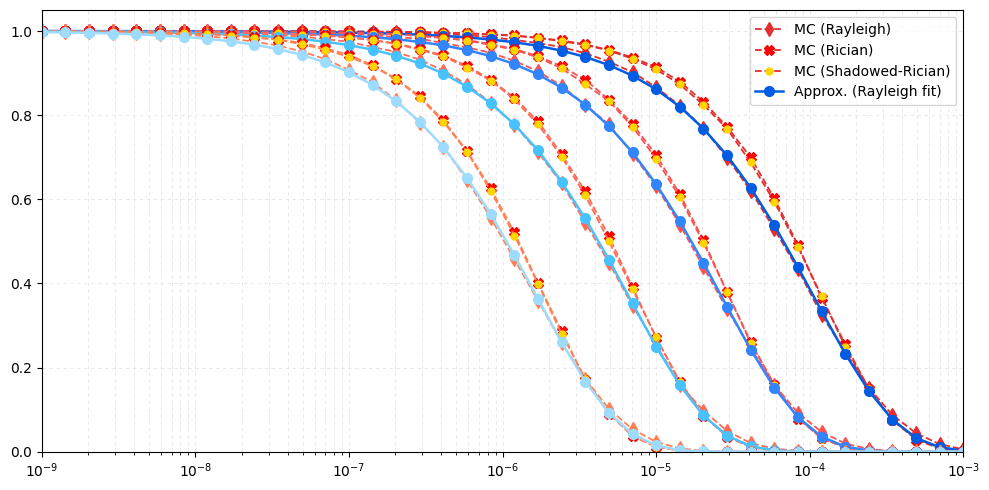

In [65]:
# Color palettes (keep exactly as given)
colors_red = np.array([
    [228, 46, 46],
    [249, 84, 84],
    [255, 108, 86],
    [255, 130, 86],
]) / 255.
colors_blue = np.array([
    [0, 92, 226],
    [49, 133, 255],
    [72, 194, 255],
    [158, 220, 255],
]) / 255.

fontsize = 16

# Marker mapping per channel model (distinct markers; same color per distance)
marker_map_mc = {
    'rayleigh': 'd',          # diamond
    'rician': 'X',            # square
    'shadowed_rician': '.',   # triangle_up
}
marker_approx = 'o'  # approximation marker (Rayleigh fit only)


# ---------- (C) Plot the results ----------
plt.figure(figsize=(10, 5))

for i, (legit_distance, results) in enumerate(all_results.items()):
    # (C-1) Plot Monte Carlo (same red per distance, different markers per model)
    for j, model in enumerate(channel_models):
        label_mc = None
        # Show legend entries only once (first distance) so legend is concise
        if model == 'rayleigh':
            label_mc = "MC (Rayleigh)" if i == 0 else None
            marker_color = colors_red[i]
        elif model == 'rician':
            label_mc = "MC (Rician)" if i == 0 else None
            marker_color = "#ff0000"
        elif model == 'shadowed_rician':
            label_mc = "MC (Shadowed-Rician)" if i == 0 else None
            marker_color = "#ffd500"

        plt.plot(
            density_list,
            results["mc"][model]["spsc_array"],
            label=label_mc,
            marker=marker_map_mc[model],
            markerfacecolor = marker_color,
            markeredgecolor = marker_color,
            color=colors_red[i],
            linestyle='--',
            linewidth=1.3,
            markersize=7 if model != 'shadowed_rician' else 10,
        )

    # (C-2) Plot approximation curve (Rayleigh fit only, same blue per distance)
    label_ap = "Approx. (Rayleigh fit)" if i == 0 else None
    plt.plot(
        density_list,
        results["fit"]["approx_spsc_array"],
        label=label_ap,
        marker=marker_approx,
        color=colors_blue[i],
        linestyle='-',
        linewidth=1.8,
        markersize=7,
    )
plt.xscale('log')
# plt.xlabel('Eavesdropper Density (log scale)', fontsize=fontsize)
# plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0, 1.05)
plt.xlim(density_list[0], density_list[-1])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=(0, (5, 5)), linewidth=0.5, color="#e0e0e0")
plt.tight_layout()
plt.savefig("spsc_vs_density.eps", format='eps', dpi=300)
plt.show()